In [1]:
import sys
sys.path.append("/Users/jasonbenn/code/neighborhood/neighborhood")

In [45]:
from utils import fetchall, chunks, flatten, sliding_window
import json
import datetime
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import torch
np.set_printoptions(precision=2)
torch.set_printoptions(precision=2)
%matplotlib inline

## Parsing out event histories

In [3]:
from asgiref.sync import sync_to_async

query = """select *, jsonb_array_length(price_history) / 4 len_history
from zillow_addresses
where jsonb_array_length(price_history) / 4 > 1;"""

listings = await sync_to_async(lambda: fetchall(query))()

In [4]:
Counter(flatten([[y[1] for y in chunks(json.loads(x['price_history']), 4)] for x in listings]))

Counter({'Sold': 1959,
         'Pending sale': 350,
         'Price change': 457,
         'Listed for sale': 607,
         'Listing removed': 679,
         'Listed for rent': 445})

In [5]:
len(listings)

1161

In [30]:
IGNORED_EVENTS = ['Pending sale', 'Price change', 'Listed for sale']

def parse_history(history):
    raw_history = chunks(json.loads(history), 4)

    history = []
    for x in raw_history:
        if x[1] in IGNORED_EVENTS:
            continue
            
        if x[1] == "Listing removed" and x[2] in ["--", "-- "]:
            continue
            
        try:
            price = int(re.match("\$([\d,]+)", x[2]).group(1).replace(',', ''))
        except:
            print(x)
            raise

        history.append({
            'date': datetime.datetime.strptime(x[0], "%m/%d/%Y").date(),
            'type': x[1],
            'price': price
        })
    return history


event_pairs = []

for listing in listings:
    event_pairs.extend(sliding_window(parse_history(listing['price_history']), 2))

In [38]:
Counter([len(x) for x in event_pairs])

Counter({2: 1926})

In [63]:
days_bw_events = torch.Tensor([(x[0]['date'] - x[1]['date']).days for x in event_pairs])
len_dataset = len(days_bw_events)
num_train_examples = int(len_dataset * .8)
train_data = days_bw_events[:num_train_examples]
test_data = days_bw_events[num_train_examples:]
print(training_data.shape, test_data.shape)

torch.Size([1540]) torch.Size([386])


## Plot distributions

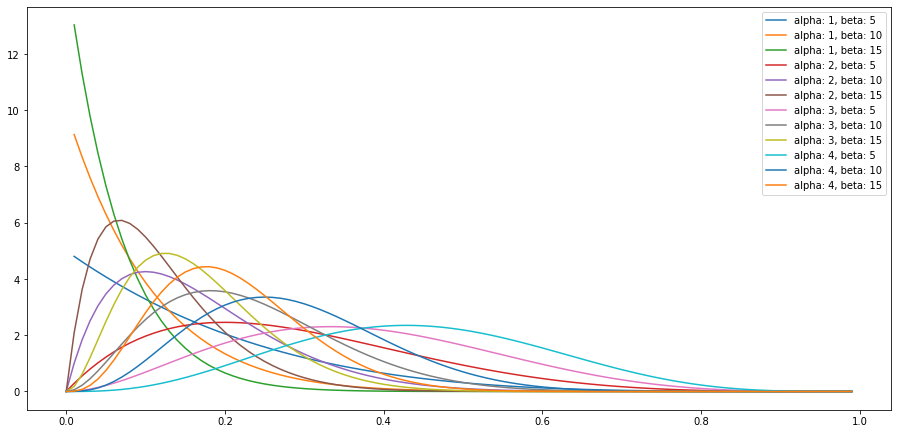

In [155]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 2, 1.4])

for alpha in np.arange(1, 5):
    for beta in np.arange(5, 20, 5):
        dist = torch.distributions.Beta(alpha, beta)
        xs = torch.arange(0, 1, 0.01)
        ys = dist.log_prob(xs).exp()
        line, = ax.plot(xs, ys, '-', label=f"alpha: {alpha}, beta: {beta}")
        ax.legend()

plt.show()

tensor([2582.12, 2003.84, 4982.71, 4591.63, 2481.96, 1859.17, 4658.44, 3918.05,
        3271.12, 2238.79, 1343.43, 3360.84, 3471.41, 4375.10, 2712.07, 5192.93,
        4192.29, 4970.73, 2689.10, 2177.83, 1850.06, 3261.54, 2140.68, 3909.31,
        1645.13, 3300.32, 3824.92, 2536.76, 3101.60, 3845.63, 1279.90, 3698.30,
        2035.33, 1481.77, 3001.65, 4394.41, 2117.99, 3373.00, 4094.91, 4714.79,
        5762.88, 3578.32, 2780.92, 4302.07, 3732.97, 2473.36,  733.18, 2512.12,
        3820.34, 3005.17, 3949.81,  499.82, 4526.78, 4205.64, 1094.47, 2360.31,
        3278.23, 3714.55, 3892.04, 2446.79, 2146.93, 4775.86, 2943.93, 3234.00,
        2310.94, 3789.96, 2549.01, 3586.61, 4643.89,  972.47, 3366.22, 2587.41,
        2117.50, 1841.27, 3420.79, 3343.91, 3387.13, 3191.13, 1652.63, 5436.46,
        1029.30, 3216.13, 2115.97, 1223.42, 2397.37, 3893.84, 2555.10, 2893.71,
        4699.96, 4766.22, 3398.59, 2949.11, 1810.80,  308.51, 2795.31, 2709.28,
        1169.33, 5307.58, 1241.84, 2706.